# Объявление классов

In [122]:
import numpy as np
from numba import njit
import pandas as pd

In [123]:
class ZeroCrossingSignal:
    """Класс, предназначенный для вычисления zero crossing
    """

    def __init__(self, signal: np.ndarray, harmonic_hf: float, start_offset: float, start_period: float):
        """Конструктор класса ZeroCrossingSignal

        Args:
            signal (np.ndarray): Вектор значений сигнала.
            harmonic_hf (float): Частота ВЧ
            start_offset (float): Начальный оффсет
            start_period (float): Начальный период
        """

        self.__amplitudes, self.__phases, self.__biases = self.zero_crossing(np.array(signal), harmonic_hf, start_offset, start_period)

    @staticmethod
    @njit
    # WARNING. ДАННАЯ ФУНКЦИЯ ОПТИМИЗИРОВАНА С ПОМОЩЬЮ БИБЛИОТЕКИ NUMBA. МЕНЯТЬ ЧТО-ТО ВНУТРИ НЕЕ СЛЕДУЕТ КРАЙНЕ ОСТОРОЖНО
    def zero_crossing(signal: np.ndarray, harmonic_hf: float, start_offset: float, start_period: float) -> tuple:
        """Основная функция для вычисления zero_crossing

        Args:
            signal (np.ndarray): Вектор значений сигнала. ОБЯЗАТЕЛЬНО в формате np.ndarray
            harmonic_hf (float): Частота ВЧ
            start_offset (float): Начальный оффсет
            start_period (float): Начальный период

        Returns:
            np.ndarray: Вектор амлитуд
            np.ndarray: Вектор частот
            np.ndarray: Вектор смещений
        """

        # Задание изначального оффсета и изначального периода
        offset = start_offset
        period = start_period

        # Данные шаги ни в коем случае не трогать, какими бы нелогичными они не казались. Библиотеке numba нужно явно пояснить, какой тип данных
        # будет храниться в списке. Поэтому, сначала создаются спискок с любым дробным числом, а потом оно удаляется. Если задать просто пустой список,
        # то интерпретатор выдаст ошибку
        amplitudes = [1.,]
        phases = [1.,]
        biases = [1.,]

        amplitudes.pop()
        phases.pop()
        biases.pop()

        
        # Вектор определяется за циклом, чтобы не пришлось каждый раз выделять памяить
        harmonics_vector = np.array([0., 0., 0.])
        iteration = 0

        # Запуск основного цикла. Пояснения автора могут быть не точными, так как он не силен в предметной области
        while offset < (len(signal) - np.floor(period)-1):
            # Вычисление фазы (автор не значет ее физического смысла)
            phase = 2 * np.pi / period * harmonic_hf
            
            # Реалицация метода наименьших квадратов
            harmonics_vector[0] = np.sum(signal[offset:offset + int(period) + 1] * np.cos(phase * np.arange(int(period) + 1)))
            harmonics_vector[1] = np.sum(signal[offset:offset + int(period) + 1] * np.sin(phase * np.arange(int(period) + 1)))
            harmonics_vector[2] = np.sum(signal[offset:offset + int(period) + 1])

            # Кусок с нахождением матрицы P_b был вынесен в маткаде в отдельную функцию, но из-за особенностей работы numba его пришлось вставить в эту функцию
            P_b = np.array(((0., 0., 0.),
                            (0., 0., 0.),
                            (0., 0., 0.)))

            cos_vals = np.cos(phase * np.arange(int(period) + 1))
            sin_vals = np.sin(phase * np.arange(int(period) + 1))

            P_b[0, 0] = np.sum(cos_vals**2)
            P_b[0, 1] = np.sum(cos_vals * sin_vals)
            P_b[0, 2] = np.sum(cos_vals)
            P_b[1, 0] = P_b[0, 1]
            P_b[1, 1] = np.sum(sin_vals**2)
            P_b[1, 2] = np.sum(sin_vals)
            P_b[2, 0] = P_b[0, 2]
            P_b[2, 1] = P_b[1, 2]
            P_b[2, 2] = int(period) + 1

            # Вычисление коэффициентов функции вида A*cos(x) + B*sin(x) + C с помощью метода наименьших квадратов
            A, B, C = np.linalg.inv(P_b) @ harmonics_vector # ----

            # Заполнение списков
            amplitudes.append(np.sqrt(A**2 + B**2)) # Амплитуда
            phases.append(offset + (1 / phase * np.arctan2(A, -B))) # Фаза 
            biases.append(C) # Смещение
            
            # Пересчет оффсета
            offset = int(phases[iteration] + period) # перечет офсета 
            # Пересчет периода
            period = 1 / 10 * (phases[iteration] - phases[iteration-10]) if iteration > 12 else period # перечсет периода для окна 

            iteration += 1

        # Преобразование данных из списка в формат ndarray
        return np.array(amplitudes), np.array(phases), np.array(biases)
        
    @property
    def amplitudes(self):
        """np.ndarray: Амплитуды"""
        return self.__amplitudes

    @property
    def phases(self):
        """np.ndarray: Фазы"""
        return self.__phases

    @property
    def biases(self):
        """np.ndarray: Смещения"""
        return self.__biases

In [124]:
class LorentzFactors:
    """Класс для вычисления лоренц-факторов"""
    def __init__(self, phases: np.ndarray, booster_perimeter: float, delta_time: float, nuclone_mass: float, speed_of_light: float = 2.997925e10):
        """Конструктор класса LorentzFactors

        Args:
            phases (np.ndarray): Вектор со значениями фаз
            booster_perimeter (float): Периметр бустера
            delta_time (float): Шаг по времени
            nuclone_mass (float): Масса нуклона ядра
            speed_of_light (float, optional): Скорость света. Defaults to 2.997925e10.
        """

        self.__phase_difference = np.diff(phases) # Разности фаз
        self.__beta = booster_perimeter / (speed_of_light * delta_time * self.phase_difference)
        self.__gamma = 1 / np.sqrt(1 - self.beta**2)
        self.__energy = (self.gamma-1) * nuclone_mass
        self.__momentum = self.beta * self.gamma * nuclone_mass

    @property
    def phase_difference(self):
        """np.ndarray: Разности фаз"""
        return self.__phase_difference

    @property
    def beta(self):
        """np.ndarray: Бета лорец-фактор"""
        return self.__beta

    @property
    def gamma(self):
        """np.ndarray: Гамма лоренц-фактор"""
        return self.__gamma

    @property
    def energy(self):
        """np.ndarray: Полная энергия"""
        return self.__energy

    @property
    def momentum(self):
        """np.ndarray: Импульс"""
        return self.__momentum

In [125]:
class AveragedData:
    """Класс, предназначенный для работы с усредненными данными (файл маткада summary)"""
    def __init__(self, phases: np.ndarray, corrected_phases: np.ndarray, intensities: np.ndarray, averaging_window: int,
                booster_perimeter: float, delta_time: float, nuclone_mass: float, speed_of_light: float = 2.997925e10):
        """Конструктор класса AveragedData

        Args:
            phases (np.ndarray): Вектор со значениями фаз
            corrected_phases (np.ndarray): Вектор со значениями скорректированых фаз
            intensities (np.ndarray): Вектор со значениями интенсивностей
            averaging_window (int): Длина окна усренения
            booster_perimeter (float): Периметр бустера
            delta_time (float): Шаг по времени
            nuclone_mass (float): Масса нуклона
            speed_of_light (float, optional): Скорость света. Defaults to 2.997925e10.
        """
        # Сначала фазы, корректированные фазы и интенсивности просто усредняются
        self.__phases = self.average_data(phases, averaging_window)
        self.__corrected_phases = self.average_data(corrected_phases, averaging_window)
        self.__intensities = self.average_data(intensities, averaging_window)
        # На основе усредненных фаз вычисляются лоренц-факторы
        self.__lorentz_factors = LorentzFactors(self.__phases, booster_perimeter, delta_time / averaging_window, nuclone_mass, speed_of_light)

    @property
    def lorentz_factors(self):
        """LorentzFactors: Лоренц факторы для заданных фаз"""
        return self.__lorentz_factors
    
    @property
    def phases(self):
        """Усредненные фазы"""
        return self.__phases

    @property
    def corrected_phases(self):
        """Усредненные скорректированные фазы"""
        return self.__corrected_phases

    @property
    def intensities(self):
        """Усредненные интенсивности"""
        return self.__intensities
    
    @staticmethod
    def average_data(data: np.ndarray, averaging_window: int) -> np.ndarray:
        """Функция для усредненния данных. Делит вектор на батчи, длиной averaging_window, и заменяет их значения выборочным средним

        Args:
            data (np.ndarray): Вектор изначальных данных
            averaging_window (int): Величина окна усреднения

        Returns:
            np.ndarray: Вектор усредненных данных
        """
        return np.convolve(data, np.ones(averaging_window)/averaging_window, mode='valid')[::averaging_window]

In [126]:
class ParametersFCTRF:
    """Класс для вычисления параметров сигналов FCT и RF"""
    def __init__(self, signal_fct: np.ndarray, signal_rf: np.ndarray, period: float, offset_rf: int, start_correction: int,
                 harmonic_hf: int, booster_perimeter: float, delta_time: float, averaging_window_for_finding_fct_minimums: int,
                 averaging_window: int, booster_parameter_1: float, booster_parameter_2: float, nuclone_mass: float = 938.256e6, phase_offset: int = 0,
                 charge_number: int = 28, electron_charge: float = 1.6021e-19, speed_of_light: float = 2.997925e10):
        """Конструктор класса ParametersFCTRF. Выполняет расчеты четырех файлов в маткаде. Применяется к половине сигнала

        Args:
            signal_fct (np.ndarray): Вектор значений сигнала FCT
            signal_rf (np.ndarray): Вектор значений сигнала RF
            period (float): Период обращения
            offset_rf (int): Оффсет к сигналу RF (можно интерпретировать, как оффсет между сигналами)
            start_correction (int): Поправка к старту (в маткаде delta_iB)
            harmonic_hf (int): Частота ВЧ
            booster_perimeter (float): Периметр бустера
            delta_time (float): Шаг по времени
            averaging_window_for_finding_fct_minimums (int): Величина окна сглаживания, испольуемого в при нахождении минимумов сигнала fct
            averaging_windos (int): Величина окна усреднения, используемого в классе AveragedData  
            booster_parameter_1 (float): Первый параметр бустера (паспортное значение)
            booster_parameter_2 (float): Второй параметр бустера (паспортное значение). Автор не знает их природу, поэтому могут потребоваться более осмысленные названия
            nuclone_mass (float, optional): Масса нуклона в ядре. Defaults to 938.256e6.
            phase_offset (int, optional): Оффсет для фаз. Смысл его использования автору ясен не до конца, однако везде он был равным 2. Defaults to 0.
            charge_number (int, optional): Зарядовое число. Defaults to 28.
            electron_charge (float, optional): Заряд электрона. Defaults to 1.6021e-19.
            speed_of_light (float, optional): Скорость света. Defaults to 2.997925e10.
        """

        # Вычесление zero-crossing для сигнала RF
        self.__zero_crossing_rf = ZeroCrossingSignal(signal_rf, harmonic_hf, offset_rf, period)
        # Для удобства, фазы зеро-кроссинга сохраняются в отдельное поле
        self.__phases = self.__zero_crossing_rf.phases
        # Округление фаз, вычисленных при зеро-кроссинге в меньшую сторону. Так же, отбрасывается первое значение
        self.__discretized_phases = np.floor(self.zero_crossing_rf.phases[1:]).astype(int)
        # Вычисление минимумов сигнала FCT со сглажианием
        self.__fct_minimums = self.signal_minimums_with_averaging(signal_fct[start_correction:], self.discretized_phases,
                                                                averaging_window_for_finding_fct_minimums)
        # Коррекция фаз
        self.__corrected_phases = self.correct_phases(signal_fct[start_correction:], self.fct_minimums, self.zero_crossing_rf.phases,
                                                      harmonic_hf, phase_offset)
        # Вычисление интенсивностей
        self.__intensities = self.find_intensities(signal_fct[start_correction:], self.fct_minimums, self.discretized_phases[phase_offset:],
                                        delta_time, charge_number, booster_parameter_1, booster_parameter_2, electron_charge=electron_charge)    
        # Усреднение данных. Тут зачем-то добавляются нули в количестве phase_offset в начало всех векторов. Так было в файле маткада, автор это и оставил. Смысл ясен не до конца
        self.__averaged_data = AveragedData(np.hstack((np.zeros(phase_offset), self.phases[phase_offset: -phase_offset])),
                                            np.hstack((np.zeros(phase_offset), self.corrected_phases)),
                                            np.hstack((np.zeros(phase_offset), self.intensities)),
                                            averaging_window, booster_perimeter, delta_time, nuclone_mass, speed_of_light)

    @property
    def phases(self):
        """np.ndarray: Фазы зеро-кроссинга для сигнала RF"""
        return self.__phases

    @property
    def zero_crossing_rf(self):
        """ZeroCrossingSignal: Объект ZeroCrossingSignal для сигнала RF"""
        return self.__zero_crossing_rf

    @property
    def discretized_phases(self):
        """np.ndarray: Дискретизированные фазы"""
        return self.__discretized_phases

    @property
    def fct_minimums(self):
        """np.ndarray: Минимумы, вычисленные для сглаженного сигнала FCT"""
        return self.__fct_minimums

    @property
    def corrected_phases(self):
        """np.ndarray: Корректированные фазы"""
        return self.__corrected_phases

    @property
    def intensities(self):
        """np.ndarray: Интенсивности"""
        return self.__intensities

    @property
    def averaged_data(self):
        """AveragedData: Объект с усредненными данными"""
        return self.__averaged_data

    @staticmethod
    @njit
    # WARNING. ДАННАЯ ФУНКЦИЯ ОПТИМИЗИРОВАНА С ПОМОЩЬЮ БИБЛИОТЕКИ NUMBA. МЕНЯТЬ ЧТО-ТО ВНУТРИ НЕЕ СЛЕДУЕТ КРАЙНЕ ОСТОРОЖНО
    def correct_phases(signal: np.ndarray, signal_minimums: np.ndarray, phases: np.ndarray, harmonic_hf: int, phase_offset: int = 0) -> np.ndarray:
        """Вычисляет корректированные фазы. Автор не понимает что тут, и по какому принципу оно считается

        Args:
            signal (np.ndarray): Вектор значений сигнала
            signal_minimums (np.ndarray): Вектор минимумов сигнала
            phases (np.ndarray): Вектор фаз
            harmonic_hf (int): Частота ВЧ
            phase_offset (int, optional): Оффсет для фаз. Автор не имеет ни малейшего понятия, зачем он нужен. Defaults to 0.

        Returns:
            np.ndarray: Вектор скорректированных фаз
        """
        discretized_phases = phases[1:].astype('int32')
        corrected_phases = np.zeros(len(discretized_phases) - phase_offset - 1, dtype=float)

        for i in range(len(corrected_phases)):
            up_sum = np.sum((signal[discretized_phases[phase_offset+i]: discretized_phases[phase_offset+i+1]+1] - signal_minimums[i])*\
                            (np.arange(discretized_phases[phase_offset+i+1]-discretized_phases[phase_offset+i]+1) + discretized_phases[phase_offset+i] -\
                               (phases[phase_offset+i+2] + phases[phase_offset+i+1]) / 2))
            under_sum = np.sum(signal[discretized_phases[phase_offset+i]:
                                    discretized_phases[phase_offset+i+1]+1] - signal_minimums[i])
            corrected_phases[i] = 360 * harmonic_hf / (discretized_phases[phase_offset+i+1] - discretized_phases[phase_offset+i]) * (up_sum / under_sum)
        
        return corrected_phases

    @staticmethod
    @njit
    # WARNING. ДАННАЯ ФУНКЦИЯ ОПТИМИЗИРОВАНА С ПОМОЩЬЮ БИБЛИОТЕКИ NUMBA. МЕНЯТЬ ЧТО-ТО ВНУТРИ НЕЕ СЛЕДУЕТ КРАЙНЕ ОСТОРОЖНО
    def find_intensities(signal: np.ndarray, signal_minimums: np.ndarray, phases: np.ndarray, delta_time: float,
                         charge_number: int, booster_parameter_1: float, booster_parameter_2: float, electron_charge: float = 1.6021e-19) -> np.ndarray:
        """Функция для вычисление интенсивностей пучка

        Args:
            signal (np.ndarray): Вектор значений сигнала
            signal_minimums (np.ndarray): Вектор минимумов сигнала
            phases (np.ndarray): Вектор фаз
            delta_time (float): Шаг по времени
            charge_number (int): Зарядовое число
            booster_parameter_1 (float): Первый параметр бустера (паспортное значение)
            booster_parameter_2 (float): Второй параметр бустера (паспортное значение). Автор не знает их природу, поэтому могут потребоваться более осмысленные названия
            electron_charge (float, optional): Заряд электрона. Defaults to 1.6021e-19.

        Returns:
            np.ndarray: Вектор интенсивностей
        """
        intensities = np.zeros((len(phases)-1))
        for i in range(len(phases)-1):
            intensities[i] = booster_parameter_1 * booster_parameter_2 / charge_number *\
            (delta_time / electron_charge) * np.sum(signal[phases[i]: phases[i+1] + 1] - signal_minimums[i])
        return intensities 

    @staticmethod
    @njit
    # WARNING. ДАННАЯ ФУНКЦИЯ ОПТИМИЗИРОВАНА С ПОМОЩЬЮ БИБЛИОТЕКИ NUMBA. МЕНЯТЬ ЧТО-ТО ВНУТРИ НЕЕ СЛЕДУЕТ КРАЙНЕ ОСТОРОЖНО
    def signal_minimums_with_averaging(signal: np.ndarray, period_nodes: np.ndarray, window_length: int) -> np.ndarray:
        """Поиск минимумов сигнала на каждом из периодов со сглаживанием

        Args:
            signal (np.ndarray): Вектор значений сигнала
            period_nodes (np.ndarray): Вектор значений - границ периодов
            window_length (int): Величина окна сглаживания

        Returns:
            np.ndarray: Вектор минимумов
        """
        result = np.zeros(len(period_nodes)-1)
        for i in range(len(period_nodes)-1):
            result[i] = np.convolve(signal[period_nodes[i]: period_nodes[i+1]], np.ones(window_length) / window_length)[window_length-1: -window_length+1].min()
        return result

In [127]:
def fft_with_corrected_frequences(data: np.ndarray, corrected_frequences: np.ndarray, number_of_samples: int = 256, number_of_values: int = None) -> np.ndarray:
    """Прямое преборазование Фурье с учетом корректировочных частот

    Args:
        data (np.ndarray): Вектор данных
        corrected_frequences (np.ndarray): Вектор корректировочных частот
        number_of_samples (int, optional): Число отсчетов для преобразования Фурье. Для корректной работы должно быть степенью двойки. Defaults to 256.
        number_of_values (int, optional): Число итоговых знячений. По умолчанию, выводятся все. Defaults to None.

    Returns:
        np.ndarray: Преобразованный вектор
    """

    # Преобразование данных в формат np.ndarray для корректной работы
    data = np.array(data)
    # Если number_of_values не был задан, берутся все значение
    if number_of_values is None: number_of_values = len(data)
    # Реализация прямого преобразования Фурье с корректировочными частотами (2j означает 2 * мнимую единицу)
    return np.fromiter((data[:number_of_samples] @
            np.exp(2j * np.pi * corrected_frequences[i] * np.arange(number_of_samples))
            for i in range(number_of_values)), 'complex')


def find_period(data: np.ndarray, number_of_samples: int = None, sample_length: int = 1, period_correction: float = 0.005,
                number_of_amplitudes_for_corrected_period: int = 10, half_window_length: int = 2) -> float:
    """Поиск периода в данных с помощью преобразования Фурье со сглаживанием и корректировочными частотами

    Args:
        data (np.ndarray): Вектор данных
        number_of_samples (int, optional): Число отсчетов для преобразования Фурье. По умолчанию равна длине данных, деленной на sample_length Defaults to None.
        sample_length (int, optional): Длина окна, в котором выполняется сглаживание методом среднего. Defaults to 10.
        period_correction (float, optional): Изменение периода, относительно которого происходит корректировка. Defaults to 0.005.
        number_of_amplitudes_for_corrected_period (int, optional): Число амплитуд после второй корректировки. Defaults to 20.
        half_window_length (int, optional): Дляга полуокна, в котором будет производится регрессия. Defaults to 5.

    Returns:
        float: Значение периода
    """

    # Если значение number_of_samples не задано, оно будет равнятся длине данных, деленой на длину сэмпла
    if number_of_samples is None: number_of_samples = len(data) // sample_length
    # Перевод данных в формат np.ndarray для корректной работы
    data = np.array(data)
    # Разделение данных на numer_of_samples участков по sample_length значений для последующего сглаживания
    sampled_data = data[:(number_of_samples * sample_length)].reshape(-1, sample_length)
    # Сглаживание данных на каждом из участков посредством усреднения
    smoothed_data = pd.DataFrame(sampled_data.T).mean().to_numpy()
    # Применение прямого преобразования Фурье для сглаженных данных. Нахождение амплитуд
    fourier_decomposition_amplitudes = np.abs(np.fft.fft(smoothed_data, norm='forward'))
    # Нахождение несущей частоты для полученных амплитуд
    carrier_frequency = np.argmax(fourier_decomposition_amplitudes)
    # Проверка на неравенство несущей частоты нулю
    if carrier_frequency == 0: raise ValueError("Incorrect_data. Carrier frequency can't be zero")
    # Нахождения периода в данных после сглаживания
    period_after_smoothing = number_of_samples * sample_length / carrier_frequency
    # Нахождение корректировочных периодов
    correction_periods = period_after_smoothing * (1 + period_correction * (2*np.arange(number_of_amplitudes_for_corrected_period)
                                                                           / number_of_amplitudes_for_corrected_period - 1)) # Уточненные периоды для каждого окна
    # Применение прямого преобразования Фурье к данным с учетом корректировочных периодов. Нахождение амплитуд
    fourier_decomposition_amplitudes_with_correction_periods = 1 / (number_of_samples * sample_length) *\
        np.abs(fft_with_corrected_frequences(data, 1 / correction_periods,
                                      number_of_samples*sample_length,
                                      number_of_amplitudes_for_corrected_period))
    # Нахождение несущей частоты  (или несущего периода) для полученных на предыдущем шаге амплитудах
    carrier_frequency_in_corrected_spectrum = np.argmax(fourier_decomposition_amplitudes_with_correction_periods)
    # Нахождение значений отклонений от несущего периода. В данном случае, в обе стороны откладывается по half_window_length значений
    deviations_form_carrier_period_slice = correction_periods[carrier_frequency_in_corrected_spectrum-half_window_length:
                                                             carrier_frequency_in_corrected_spectrum+half_window_length+1] -\
                                            carrier_frequency_in_corrected_spectrum
    # Аналогично, берется такое же окно для амплитуд.
    fourier_decomposition_amplitudes_with_correction_periods_slice =\
        fourier_decomposition_amplitudes_with_correction_periods[carrier_frequency_in_corrected_spectrum-half_window_length:
                                                                carrier_frequency_in_corrected_spectrum+half_window_length+1]
    # Построение квадратичной регрессии по отклонениям и амплитудам
    square_regressions_coefficients = np.polyfit(deviations_form_carrier_period_slice,
                                                fourier_decomposition_amplitudes_with_correction_periods_slice, 2)
    # Нахождение итогового периода в данных
    data_period = carrier_frequency_in_corrected_spectrum - (square_regressions_coefficients[1]) / (2 * square_regressions_coefficients[0])

    return data_period

# Константы

In [128]:
nuclone_mass = 930.672 * 10**6 # Масса нуклона в ядре
charge_electron  = 1.6021 * 10**(-19) # Заряд электрона
speed_of_light = 2.997925 * 10**10 # Скорость света

# Параметры

In [129]:
charge_number = 28 # Зарядовое число
booster_perimeter = 21096 # Периметер бустера

# Некие паспортные значения для бустера
booster_parameter_1 = 8.6e-5
booster_parameter_2 = 0.2e-3

delta_time = (5e7)**(-1) # Шаг по времени
start_correction = 10 # Поправка к старту
data_length = 5_000_000 # Длина данных (+1 была добавлена для соответствия маткаду)
phase_offset = 2 # Оффсет для фаз. Автор не знает, зачем он нужен
averaging_window_for_finding_fct_minimums = 13 # Окно сглаживание, нужное для нахождения минимумов сигнала fct
averaging_window = 20 # Окно усреднения для использования его в классе AveragedData
bytes_to_skip_for_second_half = 11_000_000 # Номер первого байта во второй половине сигнала

In [130]:
# Параметры ниже идут раздельно для каждой из частей сигнала
half_names = 'first_half', 'second_half' # Просто названия ключей словарей
period = {'first_half': 311.618, 'second_half': 61.591} # Начальный период
harmonic_hf = {'first_half': 5, 'second_half': 1} # Частота ВЧ
offset_rf = {'first_half': 10, 'second_half': 112} # Оффсет сигнала RF

In [131]:
# Пути до каждого из сигналов
signals_fct_filepaths = [r'data/booster_acceleration/test/15_12_22_booster_fct_1.bin',
                         r'data/booster_acceleration/test/15_12_22_booster_fct_2.bin',
                         r'data/booster_acceleration/test/15_12_22_booster_fct_3.bin']

signals_rf_filepaths = [r'data/booster_acceleration/test/15_12_22_booster_rf_1.bin',
                        r'data/booster_acceleration/test/15_12_22_booster_rf_2.bin',
                        r'data/booster_acceleration/test/15_12_22_booster_rf_3.bin']

# Расчеты

Чтение данных из файлов

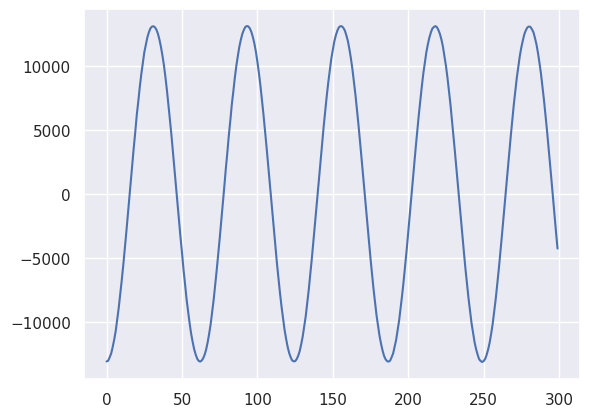

In [177]:
plt.plot(signals_rf[0]['first_half'][:300])

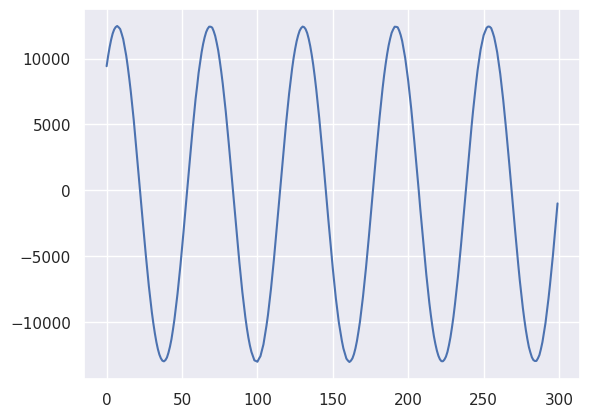

In [176]:
plt.plot(signals_rf[0]['second_half'][:300])

In [132]:
signals_rf = []
signals_fct = []
for signal_fct_filepath, signal_rf_filepath in zip(signals_fct_filepaths, signals_rf_filepaths):
    signals_rf.append({'first_half': np.fromfile(signal_rf_filepath, dtype='int16')[:data_length],
                      'second_half': np.fromfile(signal_rf_filepath, dtype='int16', offset=bytes_to_skip_for_second_half)[:data_length]})

    signals_fct.append({'first_half': np.fromfile(signal_fct_filepath, dtype='int16')[:data_length],
                       'second_half': np.fromfile(signal_fct_filepath, dtype='int16', offset=bytes_to_skip_for_second_half)[:data_length]})

Проведение основных расчетов. В результате, получаем список из словарей. Например, чтобы обратится к результатам расчетов для второй половины первого сигнала, нужно написать `parameters_fct_rf[0]['second_half']`

In [133]:
parameters_fct_rf = []
for i in range(len(signals_rf)):
    part_separated = []
    for key in half_names:
        part_separated.append(ParametersFCTRF(signal_fct=signals_fct[i][key], signal_rf=signals_rf[i][key], period=period[key],
                                             offset_rf=offset_rf[key], start_correction=start_correction,
                                             harmonic_hf=harmonic_hf[key], booster_perimeter=booster_perimeter, delta_time=delta_time,
                                             phase_offset=phase_offset, averaging_window_for_finding_fct_minimums=averaging_window_for_finding_fct_minimums,
                                             averaging_window=averaging_window, charge_number=charge_number, booster_parameter_1=booster_parameter_1,
                                             booster_parameter_2=booster_parameter_2))
    parameters_fct_rf.append(dict(zip(half_names, part_separated)))

# Обработка результатов

Импорт библиотек, необходимых для построения графиков

In [134]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Графики по разным частям

Данные графики строятся отдельно для каждой из половинок сигналов. С помощью параметров `number` и `half_name`, можно указать для какого конкретно из сигналов и для какой конкретно половины нужно построить графики

In [178]:
number = 0
half_name = 'first_half'

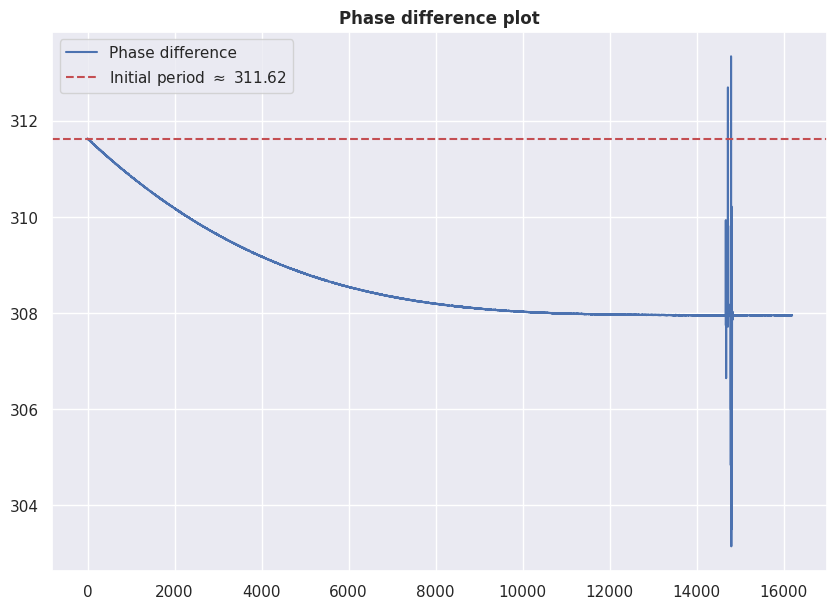

In [179]:
plt.figure(figsize=(10, 7))
y = np.diff(parameters_fct_rf[number][half_name].phases)
x = np.arange(len(y))
plt.plot(x, y, label='Phase difference')
plt.axhline(y=period[half_name], color='r', linestyle='--', label=f'Initial period $\\approx$ {round(period[half_name], 2)}')
plt.title('Phase difference plot',fontweight='bold')
plt.legend();

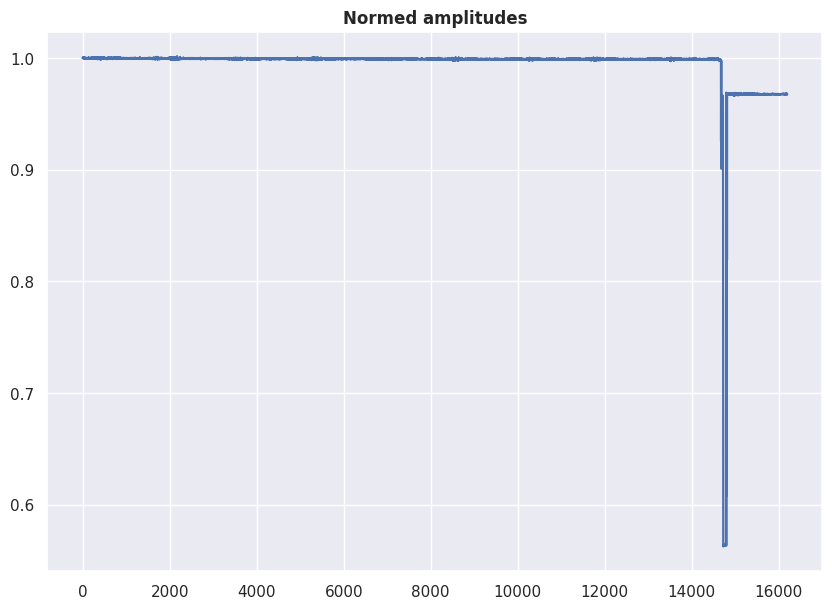

In [137]:
plt.figure(figsize=(10, 7))
y = parameters_fct_rf[number][half_name].zero_crossing_rf.amplitudes
x = np.arange(len(y))
plt.plot(x, y/y[0])
plt.title('Normed amplitudes',fontweight='bold');

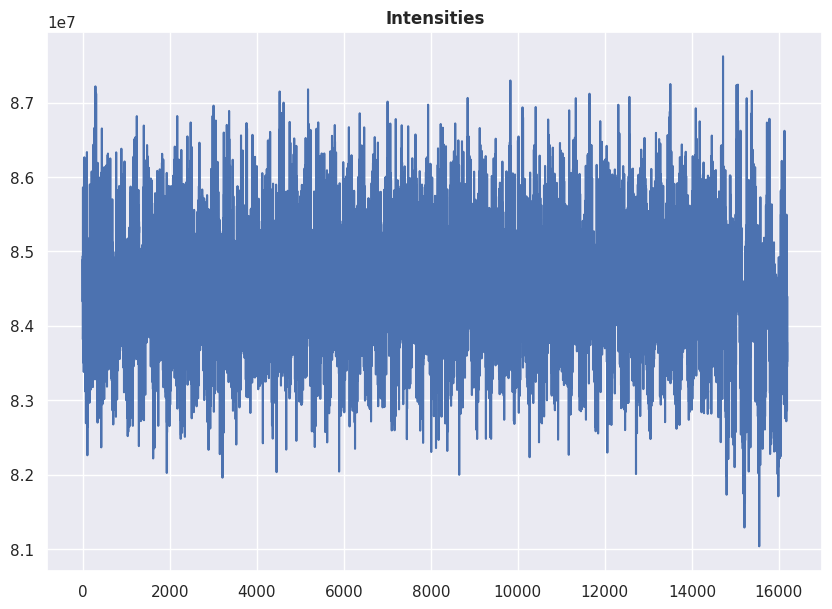

In [138]:
plt.figure(figsize=(10, 7))
y = parameters_fct_rf[number][half_name].intensities
x = np.arange(len(y))
plt.plot(x, y)
plt.title('Intensities',fontweight='bold');

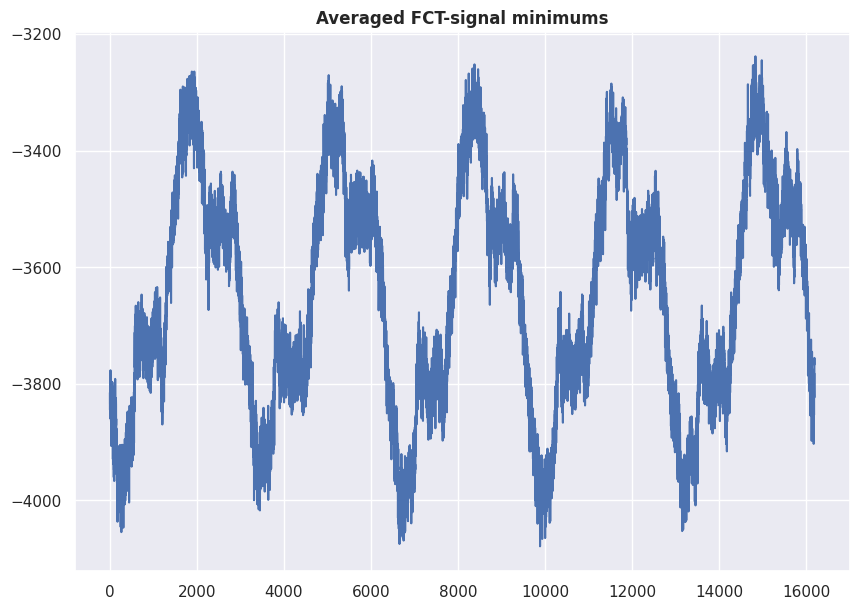

In [139]:
plt.figure(figsize=(10, 7))
y = parameters_fct_rf[number][half_name].fct_minimums
x = np.arange(len(y))
plt.plot(x, y)
plt.title('Averaged FCT-signal minimums',fontweight='bold');

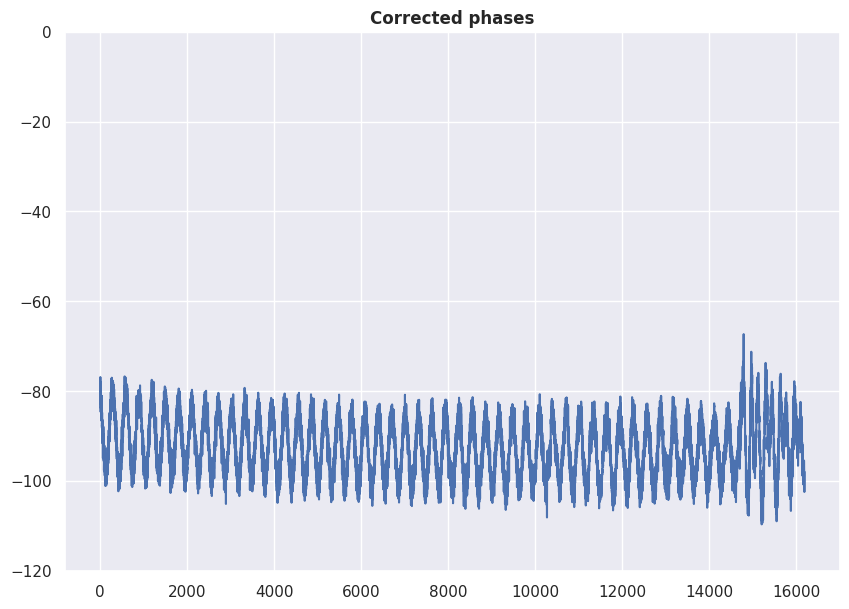

In [140]:
plt.figure(figsize=(10, 7))
y = parameters_fct_rf[number][half_name].corrected_phases
x = np.arange(len(y))
plt.plot(x, y)
plt.title('Corrected phases',fontweight='bold');
plt.ylim([-120, 0]);

In [141]:
# Создаем график Plotly
fig = go.Figure()

# Добавляем первый график на основную ось y
y = parameters_fct_rf[number][half_name].averaged_data.corrected_phases
x = np.arange(len(y))
fig.add_trace(go.Scatter(x=averaging_window * x, y=y, mode='lines', line=dict(color='red'), name='Corrected phases')) 

# Добавляем второй график на дополнительную ось y
y = parameters_fct_rf[number][half_name].averaged_data.intensities
fig.add_trace(go.Scatter(x=averaging_window * x, y=y[x], mode='lines',line=dict(color='blue'), name='Intetsities', yaxis='y2'))

# Настраиваем общий вид графика
fig.update_layout(
    title='',
    yaxis=dict(title='Corrected phases', range=[-120, -60]),
    yaxis2=dict(title='Intensities', overlaying='y', side='right')
)

# Изменяем размер окна графика
fig.update_layout(
    width=1200,   # Ширина окна в пикселях
    height=600   # Высота окна в пикселях
)

# Отображаем график
fig.show()

## Общие графики

Данные графики строятся для всех сигналов вместе. В данном случае, сигнала только два, и если их будет больше, доп графики можно будет добавить вручную по такому же принципу. Автоматизировать этот процесс достаточно проблематично, так как для лучшего вида параметры приходится подгонять вручную

На основе фаз вычисляется реальное время

In [142]:
real_time = {}
real_time['first_half'] = delta_time * parameters_fct_rf[0]['first_half'].averaged_data.phases
real_time['second_half'] = delta_time * parameters_fct_rf[0]['second_half'].averaged_data.phases + bytes_to_skip_for_second_half/2 * delta_time

In [143]:
real_time = []
for i in range(len(signals_rf)):
    real_time.append(
        {'first_half': delta_time * parameters_fct_rf[i]['first_half'].averaged_data.phases,
         'second_half': delta_time * parameters_fct_rf[i]['second_half'].averaged_data.phases + bytes_to_skip_for_second_half/2 * delta_time})

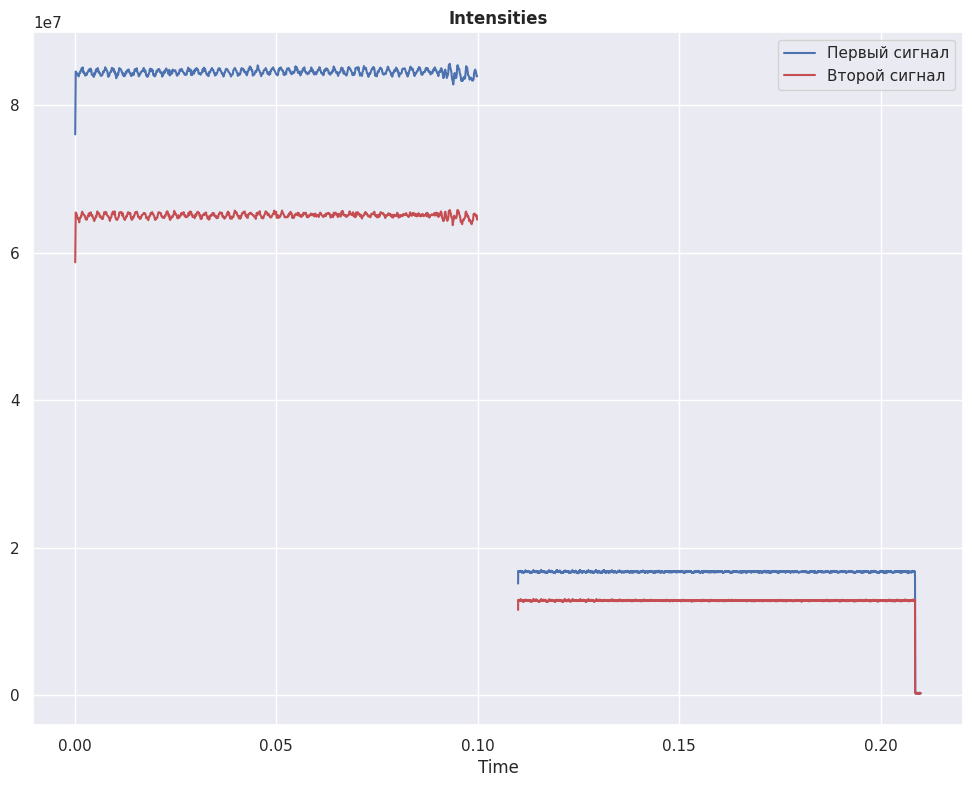

In [144]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'], parameters_fct_rf[0]['first_half'].averaged_data.intensities, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'], parameters_fct_rf[0]['second_half'].averaged_data.intensities, color='b')

plt.plot(real_time[1]['first_half'], parameters_fct_rf[1]['first_half'].averaged_data.intensities, color='r', label='Второй сигнал')
plt.plot(real_time[1]['second_half'], parameters_fct_rf[1]['second_half'].averaged_data.intensities, color='r')

plt.xlabel('Time')
plt.title('Intensities',fontweight='bold')
plt.legend();

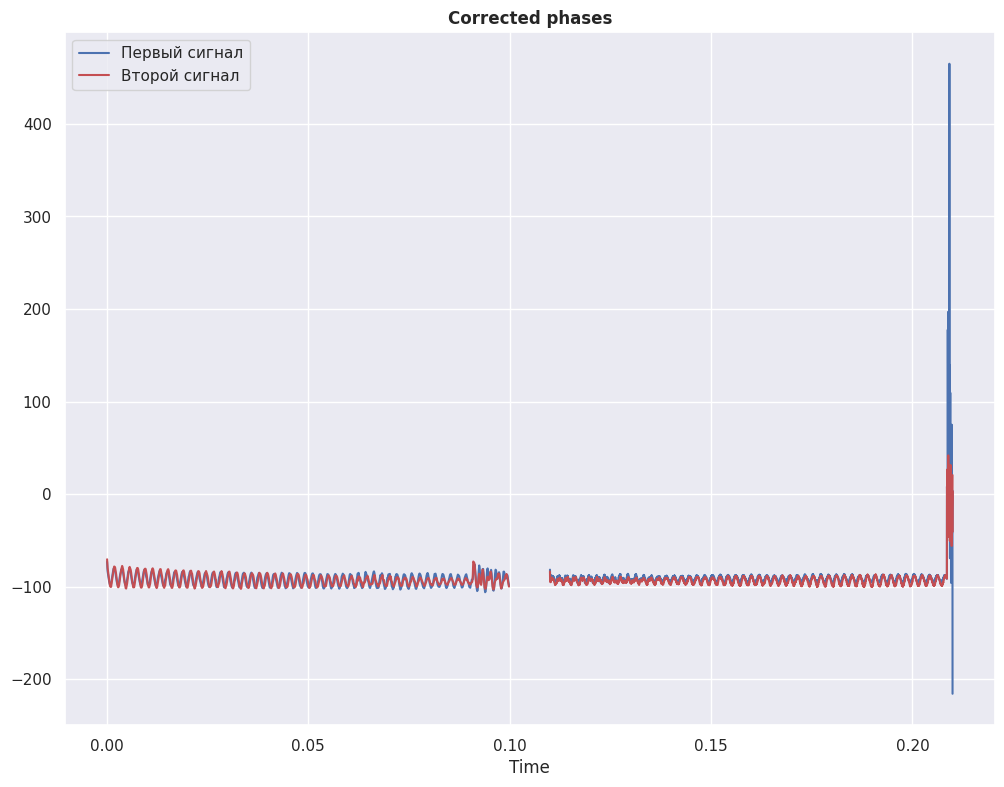

In [145]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'], parameters_fct_rf[0]['first_half'].averaged_data.corrected_phases, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'], parameters_fct_rf[0]['second_half'].averaged_data.corrected_phases, color='b')

plt.plot(real_time[1]['first_half'], parameters_fct_rf[1]['first_half'].averaged_data.corrected_phases, color='r', label='Второй сигнал')
plt.plot(real_time[1]['second_half'], parameters_fct_rf[1]['second_half'].averaged_data.corrected_phases, color='r')

plt.xlabel('Time')
plt.title('Corrected phases',fontweight='bold')
plt.legend();

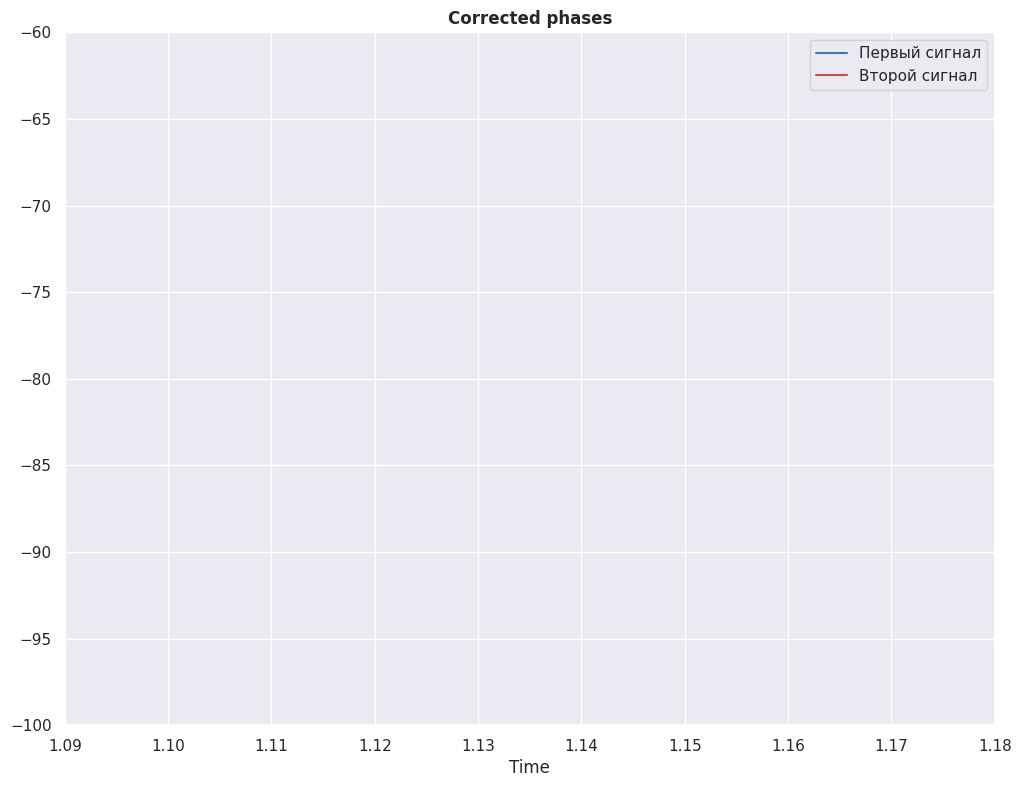

In [146]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'], parameters_fct_rf[0]['first_half'].averaged_data.corrected_phases, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'], parameters_fct_rf[0]['second_half'].averaged_data.corrected_phases, color='b')

plt.plot(real_time[1]['first_half'], parameters_fct_rf[1]['first_half'].averaged_data.corrected_phases, color='r', label='Второй сигнал')
plt.plot(real_time[1]['second_half'], parameters_fct_rf[1]['second_half'].averaged_data.corrected_phases, color='r')

plt.xlabel('Time')
plt.title('Corrected phases',fontweight='bold')
plt.xlim([1.09, 1.18])
plt.ylim([-100, -60])
plt.legend();

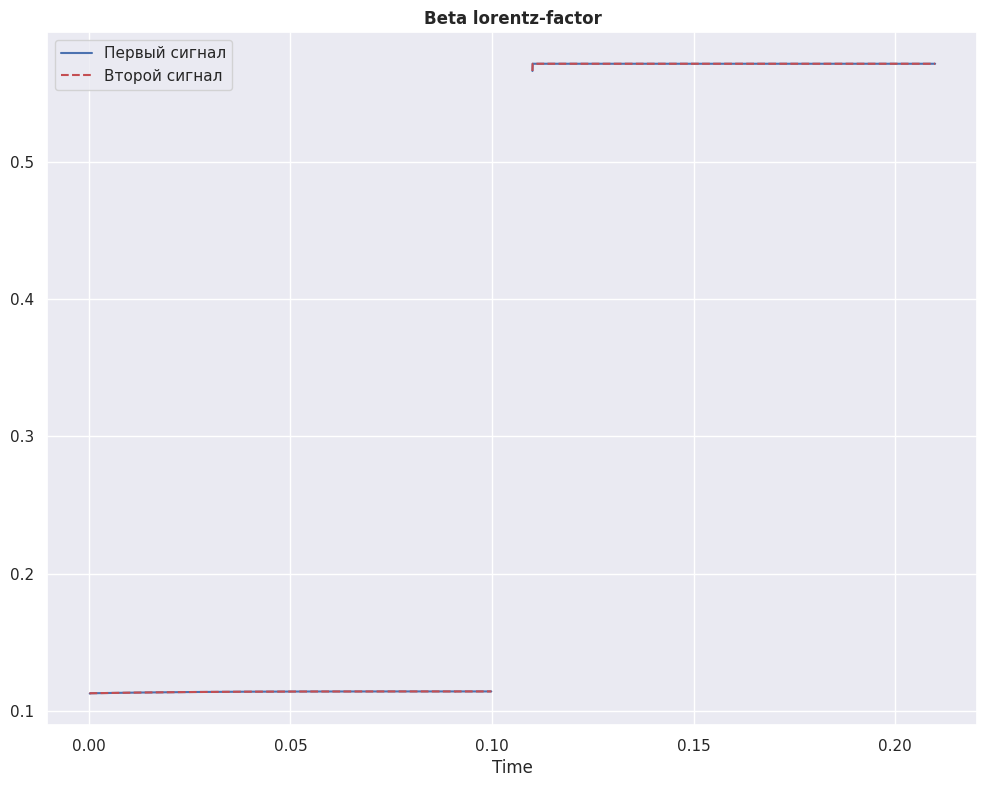

In [147]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'][1:], parameters_fct_rf[0]['first_half'].averaged_data.lorentz_factors.beta, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'][1:], parameters_fct_rf[0]['second_half'].averaged_data.lorentz_factors.beta, color='b')

plt.plot(real_time[1]['first_half'][1:], parameters_fct_rf[1]['first_half'].averaged_data.lorentz_factors.beta, color='r', ls='--', label='Второй сигнал')
plt.plot(real_time[1]['second_half'][1:], parameters_fct_rf[1]['second_half'].averaged_data.lorentz_factors.beta, color='r', ls='--',)

plt.xlabel('Time')
plt.title(r'Beta lorentz-factor',fontweight='bold')
plt.legend();

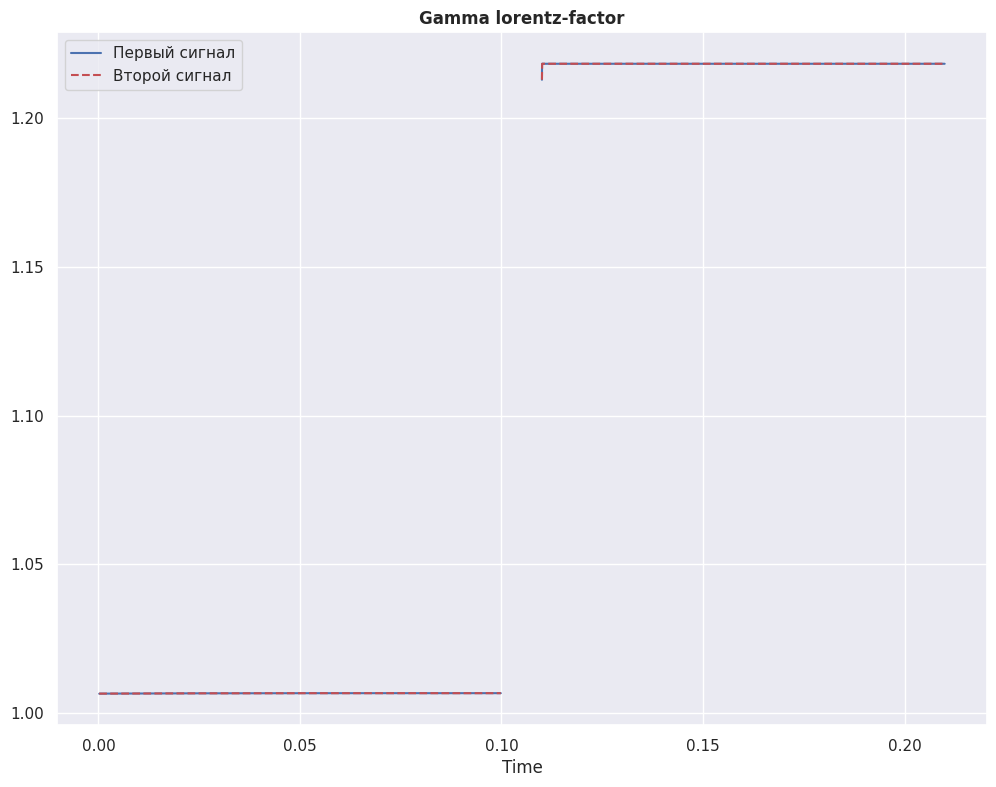

In [148]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'][1:], parameters_fct_rf[0]['first_half'].averaged_data.lorentz_factors.gamma, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'][1:], parameters_fct_rf[0]['second_half'].averaged_data.lorentz_factors.gamma, color='b')

plt.plot(real_time[1]['first_half'][1:], parameters_fct_rf[1]['first_half'].averaged_data.lorentz_factors.gamma, color='r', ls='--', label='Второй сигнал')
plt.plot(real_time[1]['second_half'][1:], parameters_fct_rf[1]['second_half'].averaged_data.lorentz_factors.gamma, color='r', ls='--',)

plt.xlabel('Time')
plt.title(r'Gamma lorentz-factor',fontweight='bold')
plt.legend();

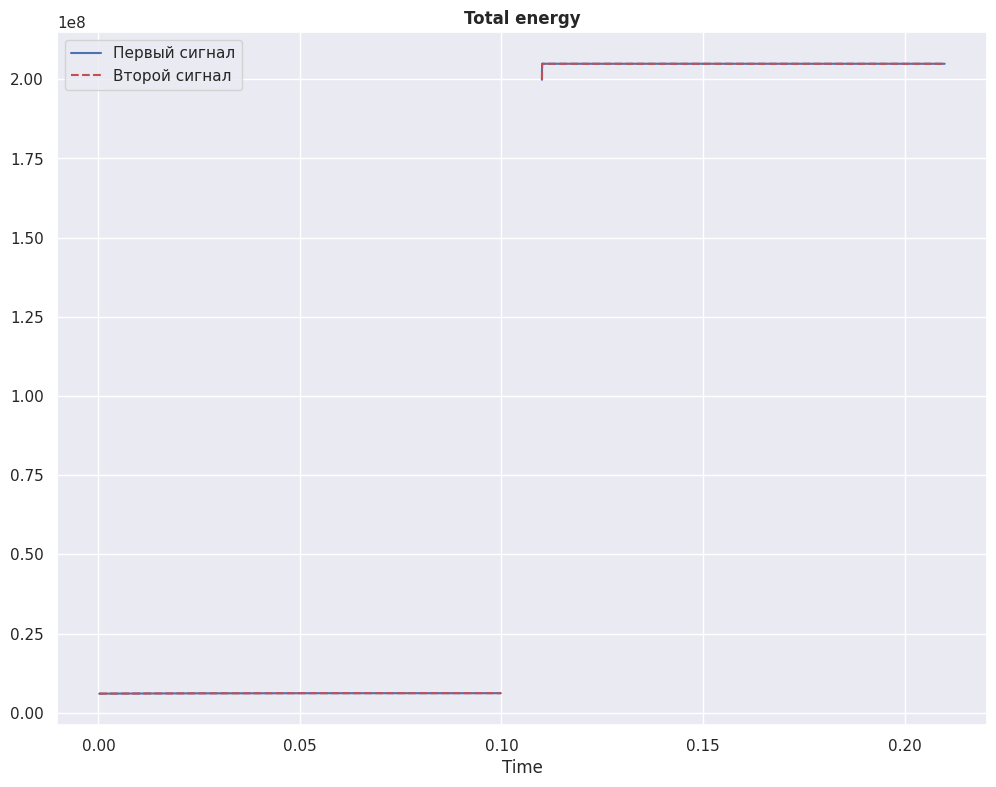

In [149]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'][1:], parameters_fct_rf[0]['first_half'].averaged_data.lorentz_factors.energy, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'][1:], parameters_fct_rf[0]['second_half'].averaged_data.lorentz_factors.energy, color='b')

plt.plot(real_time[1]['first_half'][1:], parameters_fct_rf[1]['first_half'].averaged_data.lorentz_factors.energy, color='r', ls='--', label='Второй сигнал')
plt.plot(real_time[1]['second_half'][1:], parameters_fct_rf[1]['second_half'].averaged_data.lorentz_factors.energy, color='r', ls='--',)

plt.xlabel('Time')
plt.title(r'Total energy',fontweight='bold')
plt.legend();

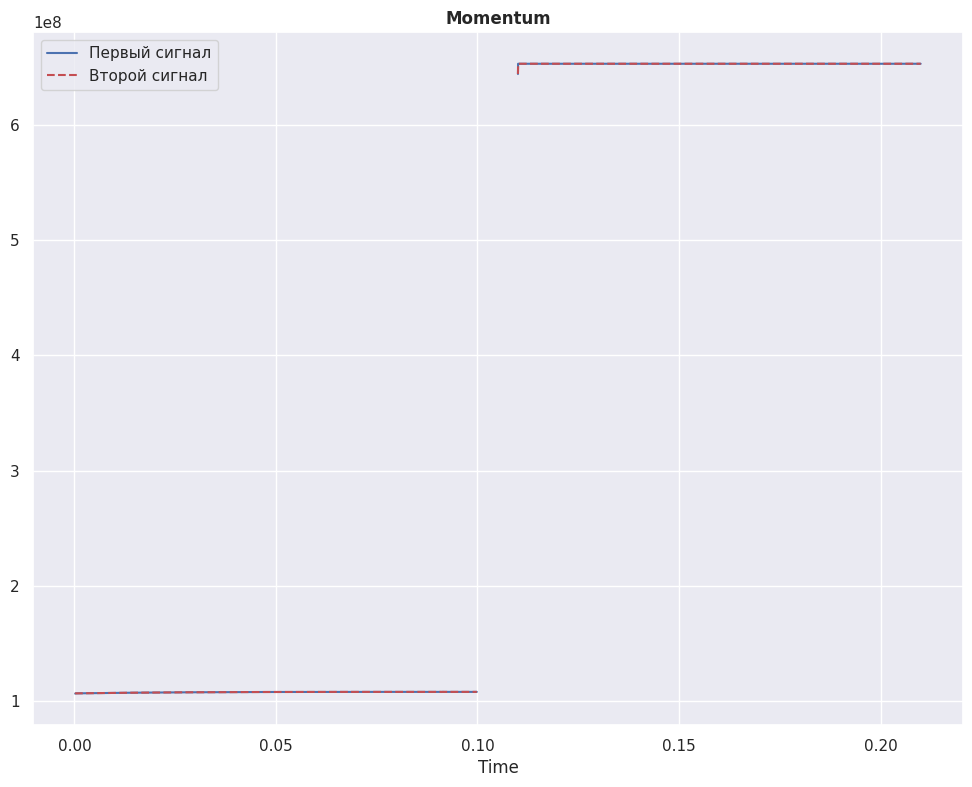

In [150]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'][1:], parameters_fct_rf[0]['first_half'].averaged_data.lorentz_factors.momentum, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'][1:], parameters_fct_rf[0]['second_half'].averaged_data.lorentz_factors.momentum, color='b')

plt.plot(real_time[1]['first_half'][1:], parameters_fct_rf[1]['first_half'].averaged_data.lorentz_factors.momentum, color='r', ls='--', label='Второй сигнал')
plt.plot(real_time[1]['second_half'][1:], parameters_fct_rf[1]['second_half'].averaged_data.lorentz_factors.momentum, color='r', ls='--',)

plt.xlabel('Time')
plt.title(r'Momentum',fontweight='bold')
plt.legend();

# Работа с данными параметрического трансформатора

In [151]:
signal_npct_filepath = 'data/booster_acceleration/27_01_23_booster_NPCT_2.bin'
signal_npct = np.fromfile(signal_npct_filepath, dtype='double')

In [152]:
half_averaging_window_npct = 5
averaging_window_npct = 2*half_averaging_window_npct + 1
delta_time_npct = 1e-3
time_offset_npct = 0.31

In [153]:
smoothed_signal_npct = 1/500 * np.convolve(signal_npct, np.ones(averaging_window_npct)/averaging_window_npct, mode='valid')

In [154]:
# Создаем график Plotly
fig = go.Figure()

# Добавляем первый график на основную ось
time_smoothed_signal_npct = delta_time_npct * np.arange(half_averaging_window_npct, len(signal_npct)-half_averaging_window_npct)-time_offset_npct 
fig.add_trace(go.Scatter(x=time_smoothed_signal_npct,
                         y=smoothed_signal_npct, mode='lines', line=dict(color='red'))) 

# Настраиваем общий вид графика
fig.update_layout(
    title='NPCT smoothed signal',
    xaxis_title='Time',
)

# Изменяем размер окна графика
fig.update_layout(
    width=1000,   # Ширина окна в пикселях
    height=600   # Высота окна в пикселях
)

# Отображаем график
fig.show()

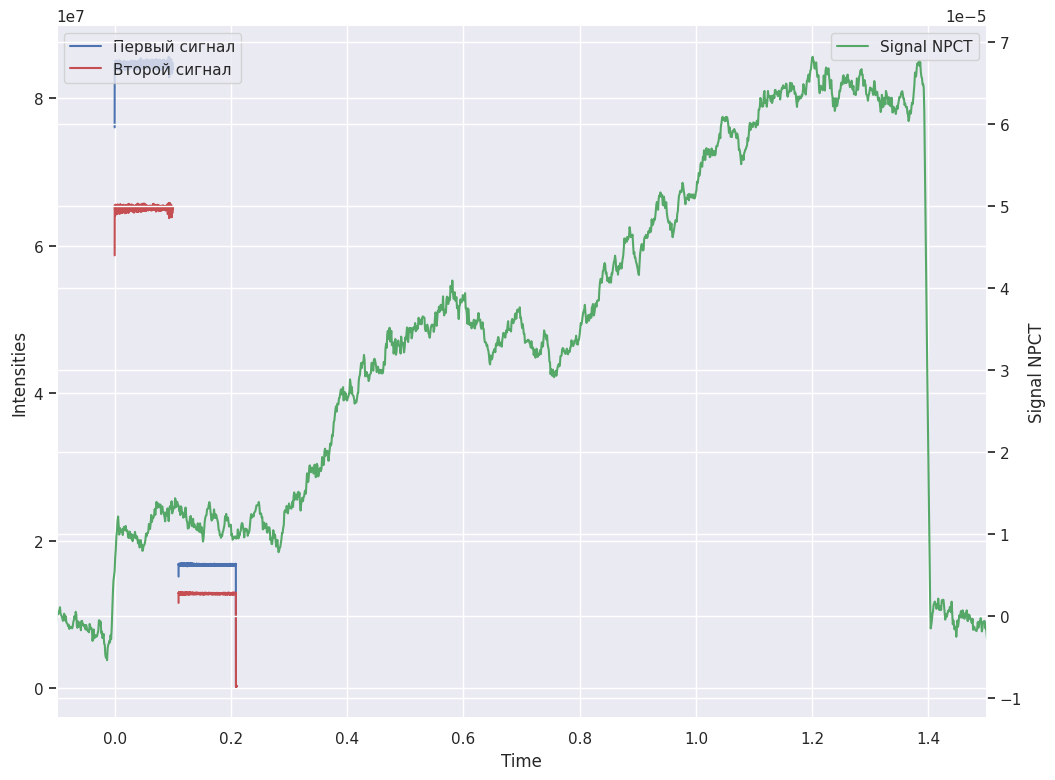

In [155]:
plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'], parameters_fct_rf[0]['first_half'].averaged_data.intensities, color='b', label='Первый сигнал')
plt.plot(real_time[0]['second_half'], parameters_fct_rf[0]['second_half'].averaged_data.intensities, color='b')

plt.plot(real_time[1]['first_half'], parameters_fct_rf[1]['first_half'].averaged_data.intensities, color='r', label='Второй сигнал')
plt.plot(real_time[1]['second_half'], parameters_fct_rf[1]['second_half'].averaged_data.intensities, color='r')
plt.legend(loc='upper left')

plt.xlabel('Time')
plt.ylabel('Intensities')

plt.twinx()
plt.ylabel('Signal NPCT')
plt.plot(time_smoothed_signal_npct, smoothed_signal_npct, color='g', label='Signal NPCT')

plt.xlim([-.1, 1.5])
plt.legend(loc='upper right');

# Работа с данными поля

In [156]:
signal_dcct_filepath = 'data/booster_acceleration/27_01_23_booster_field_2.bin'
signal_dcct = np.fromfile(signal_dcct_filepath, dtype='double') # данные магнитного поля 

In [157]:
injection_field = 221.03
sensor_parameter = 1.006
mass_number = 124
average_curvature_orbit_radius = sensor_parameter * injection_field / (2 * np.pi) * (360 / 9)

In [158]:
momentum_dcct = charge_number / mass_number * speed_of_light * 1e-4 * signal_dcct[half_averaging_window_npct: -half_averaging_window_npct] * average_curvature_orbit_radius # Импульс, вычесленный из магнитной жескости пучка на каждом отсчете
beta_dcct = momentum_dcct / (np.sqrt(momentum_dcct**2 + nuclone_mass**2)) # Лоренс фактор 
periods_dcct = booster_perimeter / (beta_dcct * speed_of_light) # Период обращения
beam_intensity_dcct = smoothed_signal_npct / (charge_electron  * charge_number) * (booster_perimeter / (beta_dcct * speed_of_light)) # Интенсивность пучка в частицах 

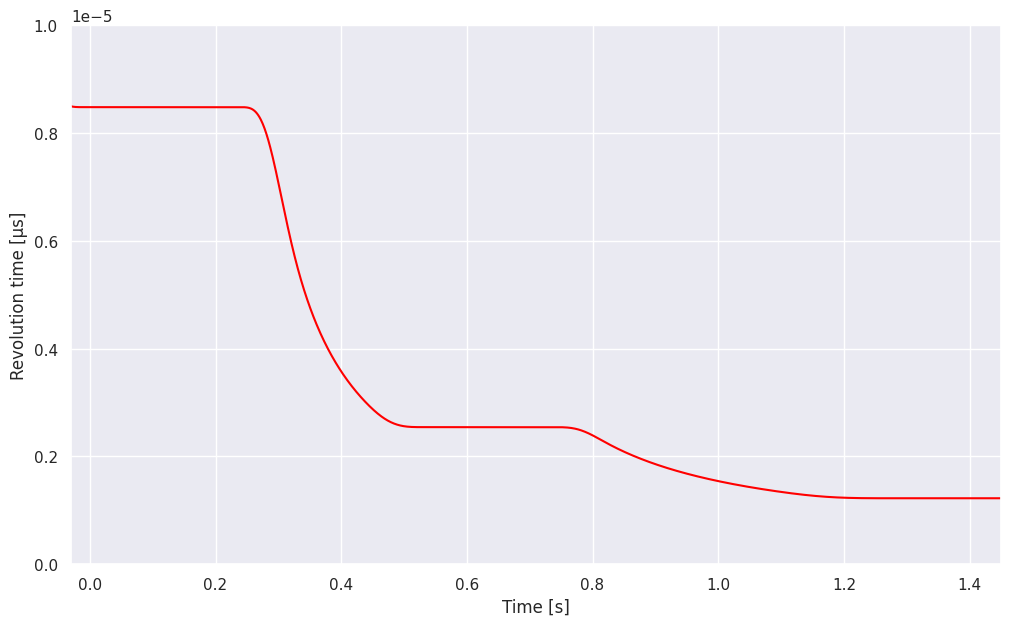

In [159]:
plt.figure(figsize=(12, 7))

plt.plot(time_smoothed_signal_npct, periods_dcct, color='red')

plt.xlim([-.03, 1.45])
plt.ylim([0, 1*10**(-5)])

plt.xlabel('Time [s]')
plt.ylabel('Revolution time [μs]');

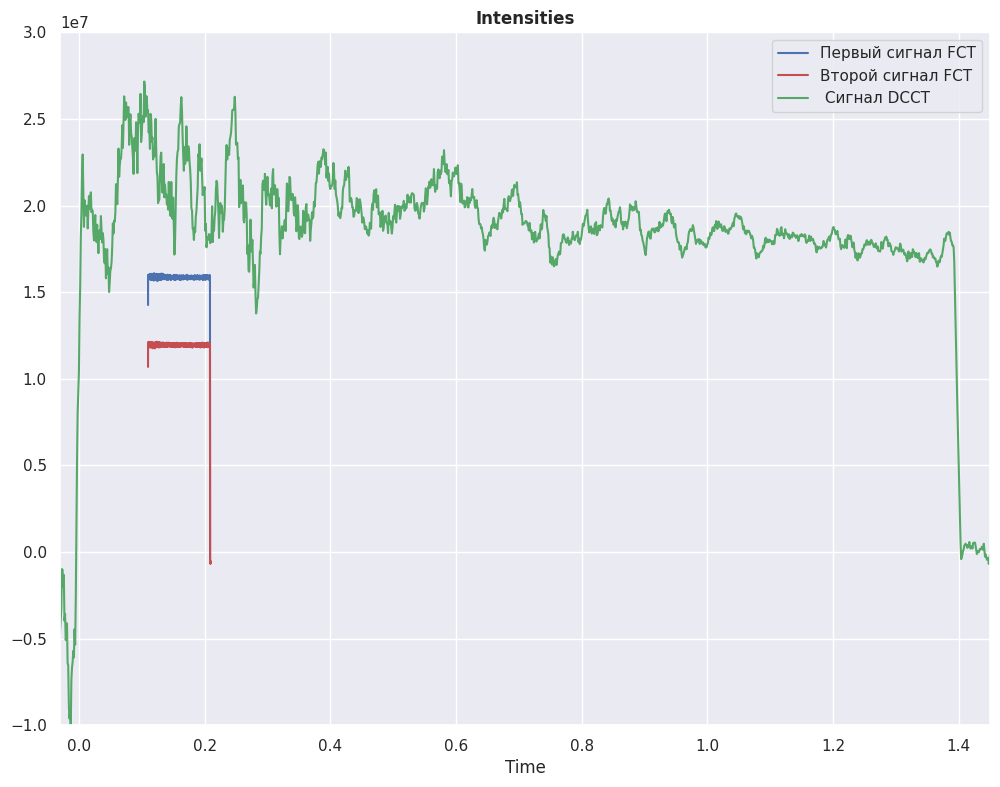

In [160]:
intensities_offset = -0.9*10**6

plt.figure(figsize=(12, 9))

plt.plot(real_time[0]['first_half'], parameters_fct_rf[0]['first_half'].averaged_data.intensities + intensities_offset, color='b', label='Первый сигнал FCT')
plt.plot(real_time[0]['second_half'], parameters_fct_rf[0]['second_half'].averaged_data.intensities + intensities_offset, color='b')

plt.plot(real_time[1]['first_half'], parameters_fct_rf[1]['first_half'].averaged_data.intensities + intensities_offset, color='r', label='Второй сигнал FCT')
plt.plot(real_time[1]['second_half'], parameters_fct_rf[1]['second_half'].averaged_data.intensities + intensities_offset, color='r')

plt.plot(time_smoothed_signal_npct, beam_intensity_dcct, color='g', label=' Сигнал DCCT')

plt.xlabel('Time')
plt.title('Intensities',fontweight='bold')
plt.xlim([-.03, 1.45])
plt.ylim([-1*10**7, 3*10**7])
plt.legend();